In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Тестове завдання Universe

Ваше завдання:

● Проведіть аналіз якості даних та зробіть очистку, якщо є потреба.

● Побудуйте розподіл того, скільки днів проходить між тріалом та першою оплатою,
опишіть висновки.

● Розрахуйте фактичний LTV за 26 тижнів життя юзера.

● Вартість залучення користувача 6 USD. Оцініть, за скільки днів настає окупність
(всіх залучених юзерів, а не тільки платників)

## Завдання 1. Аналіз якості даних

In [2]:
df =  pd.read_csv('task1.csv')
df.head(5)

,user_id,period,first_datetime,purchase_datetime,net_revenue_usd,country_code,product_id
0,201670307778915,7,2022-02-25T00:00:00Z,2022-02-25T00:00:00Z,0.0,US,week_7daytrial_6.99_new
1,23692621,7,2022-01-21T00:00:00Z,2022-01-21T00:00:00Z,0.0,US,week_7daytrial_6.99_new
2,27149658718225,7,2022-01-22T00:00:00Z,2022-01-22T00:00:00Z,0.0,JP,week_7daytrial_6.99_new
3,29101847306251,7,2021-12-05T00:00:00Z,2021-12-05T00:00:00Z,0.0,HU,week_7daytrial_6.99_new
4,29191495221901,7,2021-11-27T00:00:00Z,2021-11-27T00:00:00Z,0.0,ME,week_7daytrial_6.99_new


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1043986 entries, 0 to 1043985
Data columns (total 7 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   user_id            1043986 non-null  int64  
 1   period             1043986 non-null  int64  
 2   first_datetime     1043986 non-null  object 
 3   purchase_datetime  1043986 non-null  object 
 4   net_revenue_usd    1043986 non-null  float64
 5   country_code       1039328 non-null  object 
 6   product_id         1043986 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 55.8+ MB


In [4]:
df.shape

(1043986, 7)

Приведемо значення до правильного формату.

Змінимо тип поля user_id на string та приведемо first_datetime, purchase_datetime до типу datetime.

In [5]:
df['user_id'] = df['user_id'].astype(str)
df['first_datetime'] = pd.to_datetime(df['first_datetime'], format = '%Y-%m-%dT%H:%M:%SZ')
df['purchase_datetime'] = pd.to_datetime(df['purchase_datetime'], format = '%Y-%m-%dT%H:%M:%SZ')

Спостерігаємо наявність пропусків в колонці country_code. Подивимося на відсоток пропущених значень

In [6]:
per_null_country = df['country_code'].isna().value_counts(normalize  = True)[True]*100
print(f"Відсоток пропущенних даних в country_code: {round(per_null_country, 3)}%")

Відсоток пропущенних даних в country_code: 0.446%


Замінимо Null значення рядком 'Undefined'

In [7]:
df['country_code'].fillna('Undefined', inplace = True)

In [8]:
df.describe(include = 'all')

,user_id,period,first_datetime,purchase_datetime,net_revenue_usd,country_code,product_id
count,1043986,1.043986e+06,1043986,1043986,1.043986e+06,1043986,1043986
unique,268799,NaN,248,256,NaN,221,3
top,16273015,NaN,2021-09-15 00:00:00,2022-03-10 00:00:00,NaN,US,week_7daytrial_6.99_new
freq,3500,NaN,9865,6401,NaN,324181,1042256
first,NaN,NaN,2021-08-01 00:00:00,2021-06-20 00:00:00,NaN,NaN,NaN
last,NaN,NaN,2022-04-05 00:00:00,2022-04-05 00:00:00,NaN,NaN,NaN
mean,NaN,7.273647e+00,NaN,NaN,3.569415e+00,NaN,NaN
std,NaN,9.893986e+00,NaN,NaN,2.212534e+00,NaN,NaN
min,NaN,7.000000e+00,NaN,NaN,0.000000e+00,NaN,NaN
25%,NaN,7.000000e+00,NaN,NaN,0.000000e+00,NaN,NaN


Мінімальна дата поточної операції стоїть раніше мінімальної дати першої операції користовуча. Видалимо дані, які описують операції, які не могла початися раніше першої історичної операції користувача.


In [9]:
print(f"Всього видалено {len(df[df['purchase_datetime'] < df['first_datetime'].min()])} підозрілих операцій")
df = df.drop(np.where(df['purchase_datetime'] < df['first_datetime'].min())[0])


Всього видалено 8 підозрілих операцій


Поглянемо на правильність даних про отримання коштів за підписки.

In [10]:
df[df['product_id'] == 'week_7daytrial_6.99']['net_revenue_usd'].value_counts()

4.89    679
0.00    253
Name: net_revenue_usd, dtype: int64

245 записів відповідають продовженню підписки на 7 днів, але кошти ми не отримали, хоча тріал неможливий при продовженні підписки.

In [11]:
df[df['product_id'] == 'week_7daytrial_6.99_new']['net_revenue_usd'].value_counts()

4.89    760074
0.00    282174
Name: net_revenue_usd, dtype: int64

З підписками на тиждень або тріалом все окей

Text(0.5, 0.98, 'product_id')

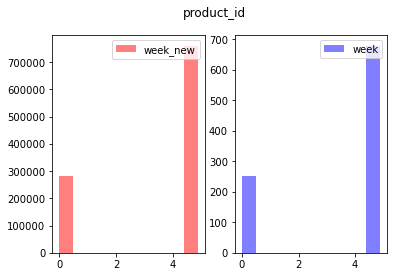

In [12]:
plt.subplot(1, 2, 1)
plt.hist(df[df['product_id'] == 'week_7daytrial_6.99_new']['net_revenue_usd'], alpha = 0.5, color = 'red', label = 'week_new')
plt.legend(loc='upper right')
plt.subplot(1, 2, 2)
plt.hist(df[df['product_id'] == 'week_7daytrial_6.99']['net_revenue_usd'], alpha = 0.5, color = 'blue', label = 'week')
plt.legend(loc='upper right')
plt.suptitle('product_id')

Спостерігаємо однакову поведінку гістограм 'week_7daytrial_6.99' та 'week_7daytrial_6.99_new'. Можемо вважати що це один і той самий вид підписки. Запишимо все як 'week_7daytrial_6.99_new'.

In [13]:
df['product_id'] = df['product_id'].replace(['week_7daytrial_6.99'], 'week_7daytrial_6.99_new')

In [14]:
df[df['product_id'] == 'year_7daytrial_49.99_new']['net_revenue_usd'].value_counts()

0.00     618
34.99    180
Name: net_revenue_usd, dtype: int64

584 рядків це дані після проходження тріалу, але коли користувач відмовився від річної підписки. 

Виявимо та очистимо дуплікати

In [15]:
df[df.duplicated()]

,user_id,period,first_datetime,purchase_datetime,net_revenue_usd,country_code,product_id
10,3175269,7,2021-10-27,2021-10-27,0.00,CI,week_7daytrial_6.99_new
12,3175269,7,2021-10-27,2021-11-11,4.89,CI,week_7daytrial_6.99_new
14,3175269,7,2021-10-27,2021-11-18,4.89,CI,week_7daytrial_6.99_new
16,3175269,7,2021-10-27,2021-11-25,4.89,CI,week_7daytrial_6.99_new
275,98991984695457,7,2021-08-27,2021-08-27,0.00,CZ,week_7daytrial_6.99_new
...,...,...,...,...,...,...,...
1043908,61906646031555,365,2021-08-11,2021-08-11,0.00,UK,year_7daytrial_49.99_new
1043909,61906646031555,365,2021-08-11,2021-08-11,0.00,UK,year_7daytrial_49.99_new
1043911,61906646031555,365,2021-08-11,2021-08-18,34.99,UK,year_7daytrial_49.99_new
1043912,61906646031555,365,2021-08-11,2021-08-18,34.99,UK,year_7daytrial_49.99_new


Маємо досить велику кількість дублікатів, видалимо їх.

In [16]:
df = df.drop_duplicates(keep='first').reset_index(drop = True)

In [17]:
df[df.duplicated()]

,user_id,period,first_datetime,purchase_datetime,net_revenue_usd,country_code,product_id


In [18]:
print(f"Всього маємо {len(df['user_id'].unique())} унікальних користувачів")

Всього маємо 268799 унікальних користувачів


In [19]:
df_amount_of_first = pd.DataFrame(df['first_datetime'].value_counts()).reset_index()
df_amount_of_first.rename(columns = {'first_datetime':'amount','index':'first_datetime'}, inplace = True)
df_amount_of_first.sort_values(by = 'first_datetime', inplace = True)
df_amount_of_first.head()


,first_datetime,amount
108,2021-08-01,4096
68,2021-08-02,5164
47,2021-08-03,5915
57,2021-08-04,5377
74,2021-08-05,5020


In [20]:
df_amount_purchase = pd.DataFrame(df['purchase_datetime'].value_counts()).reset_index()
df_amount_purchase.rename(columns = {'purchase_datetime':'amount','index':'purchase_datetime'}, inplace = True)
df_amount_purchase.sort_values(by = 'purchase_datetime', inplace = True)
df_amount_purchase.head()

,purchase_datetime,amount
244,2021-08-01,791
241,2021-08-02,1057
237,2021-08-03,1153
239,2021-08-04,1129
240,2021-08-05,1077


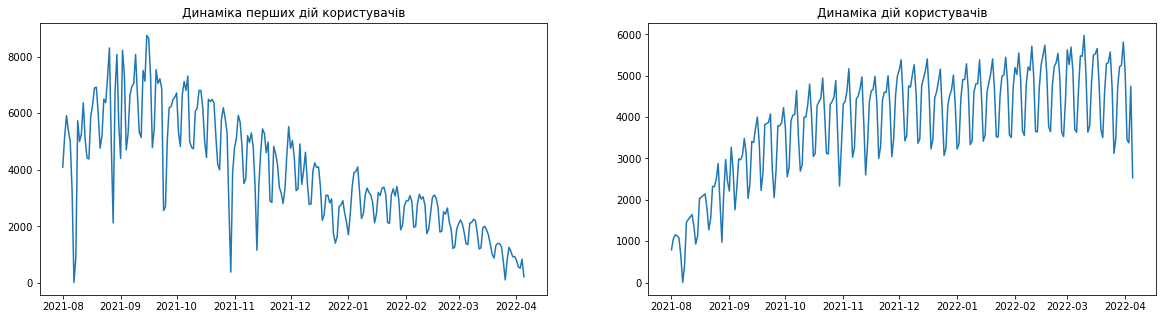

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(df_amount_of_first['first_datetime'], df_amount_of_first['amount'])
ax1.title.set_text('Динаміка перших дій користувачів')
ax2.plot(df_amount_purchase['purchase_datetime'], df_amount_purchase['amount'])
ax2.title.set_text('Динаміка дій користувачів')

За графіками бачимо, що надані дані не мають суттєвих аномалій, окрім дат там де кількість перших дій користувачів падає різко до нуля.

In [22]:
[df[i].value_counts() for i in ['period', 'net_revenue_usd']]

[7      960421
 365       738
 Name: period, dtype: int64,
 4.89     691934
 0.00     269071
 34.99       154
 Name: net_revenue_usd, dtype: int64]

Значення period та net_revenue_usd не мають зайвих значень, але проглядається явна незбалансованість, яка має очевидне пояснення.

Виявимо можливі випадки, коли поточна операція відбувається раніше першої дати операції

In [23]:
len(df[df.first_datetime > df.purchase_datetime].user_id.unique())

32

32 юзери мають дату поточної операції раніше аніж першої. Видалимо проблемних юзерів, так як їх небагато.

In [24]:
users = pd.unique(df[df.first_datetime > df.purchase_datetime].user_id)

In [25]:
df.drop(df[df['user_id'].isin(users)].index, inplace = True)

## Завдання 2. Розподіл днів між тріалом та першою оплатою

Обчислимо кількість днів віднімаючи від дати другої операції дату першої, а також не будемо враховувати користувачів, які користувалися тільки тріалом.

Залишимо датасет з користовучами, які здійснили більше однієї операції

In [26]:
df_bool = df.groupby(by = ['user_id']).count()['purchase_datetime'] == 1
mask = df_bool[df_bool == True].index
users_one_act = df[(df['user_id'].isin(mask)) & (df['net_revenue_usd'] == 0)]['user_id'].values

In [27]:
df_to_dist = df[~(df['user_id'].isin(users_one_act))]


Знайдемо розподіл

In [28]:
df_to_dist['next_datetime'] = df_to_dist.sort_values(by=['purchase_datetime'], ascending=True)\
            .groupby(['user_id'])['purchase_datetime'].shift(-1)

In [29]:
min_next = df_to_dist.groupby(by = ['user_id'])['next_datetime'].min()
min_purchase = df_to_dist.groupby(by = ['user_id'])['purchase_datetime'].min()


In [30]:
sub_days = np.ndarray(len(min_next))
for i in range(0, len(min_next)):
    sub_days = np.append(sub_days,(min_next[i] - min_purchase[i]).days)
    
sub_days

array([1.31047629e-311, 1.31054681e-311, 8.23088665e-199, ...,
       3.10000000e+001, 7.00000000e+000, 7.00000000e+000])

Text(0.5, 1.0, 'log розподіл')

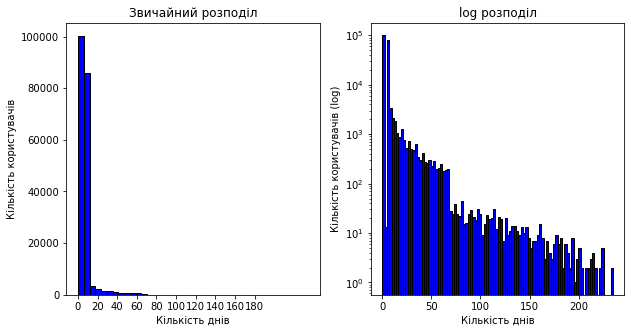

In [31]:
_, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))
ax1.hist(sub_days, bins = 40, color = 'blue', edgecolor = 'black')
ax1.set_xlabel('Кількість днів')
ax1.set_ylabel('Кількість користувачів')
ax1.xaxis.set_ticks(np.arange(0, 200, 20))
ax1.set_title('Звичайний розподіл')
ax2.hist(sub_days, bins = 100,color = 'blue', edgecolor = 'black')
ax2.set_yscale('log')
ax2.set_xlabel('Кількість днів')
ax2.set_ylabel('Кількість користувачів (log)')
ax2.set_title('log розподіл')

Можемо зробити висновок, що користувачі в основному оформлюють підписку в перші 10 днів, після активації тріалу. Велика кількість користувачів, які оплачують підписку, роблять це в перші дні користування тріалом, або навіть не користуються пробним періодом.

## Завдання 3. Розрахунок LTV за 26 тижнів

Розрахуємо LTV за досить простою формулою LTV = Lifetime * ARPU, де Lifetime - середня кількість днів 'життя' користувача, а ARPU - середній дохід від активного користувача за період. Розраховувати будемо за 26 тижнів, тобто за весь період наданий в датасеті.

Порахуємо Lifetime

In [32]:
date_min = df.groupby(by = ['user_id'])['purchase_datetime'].min()
date_max = df.groupby(by = ['user_id'])['purchase_datetime'].max()
num_uni_users = len(df['user_id'].unique())

In [36]:
sub_days_ltv = np.ndarray(len(date_min))
for i in range(0, len(date_min)):
    sub_days_ltv = np.append(sub_days_ltv,(date_max[i] - date_min[i]).days)
    
sub_days_ltv

array([ 0.,  0.,  0., ...,  0., 45.,  0.])

In [39]:
lifetime = int(np.sum(sub_days_ltv) / num_uni_users)

In [40]:
lifetime

21

Тривалість життя покупця - 21 день

Тепер розрахуємо ARPU. Період для розрахунку візьмемо - місяць. 

In [41]:
res = df.groupby([df['user_id'], df['purchase_datetime'].dt.to_period('M')])['net_revenue_usd'].sum()

In [52]:
res = pd.DataFrame(res).reset_index()

In [55]:
revenue_month = res.groupby(by = ['purchase_datetime'])['net_revenue_usd'].sum()

In [76]:
revenue_month

purchase_datetime
2021-08     76297.72
2021-09    250916.21
2021-10    384632.40
2021-11    451397.42
2021-12    526198.23
2022-01    519137.07
2022-02    505200.57
2022-03    593606.88
2022-04     79476.08
Freq: M, Name: net_revenue_usd, dtype: float64

In [58]:
av_rev_month = round(revenue_month.values.sum() / len(revenue_month), 2)

In [59]:
av_rev_month

376318.06

Середній дохід за місяць - 376318.06. Розрахуємо середній дохід за місяць з користувача.

In [62]:
arpu = round(av_rev_month / num_uni_users, 1)

In [63]:
arpu

1.4

Виходить що в середньому в місяць з одного користувача ми отримуємо 1.4$.

Тепер розрахуємо фактични LTV за 26 тижнів. Так як ARPU за місяць, то ми маємо 21/30 = 0.7 коефіцієнт пропорційності lifetime відносно місяця. Також так як ми порахували всі значення відносно повного циклу = 9 місяців - 36 тижнів, а нам потрібно за 26, то домножимо значення ltv на 26/36.

In [79]:
ltv_36 = round((lifetime* 0.7 * arpu), 2)

In [80]:
ltv_36

20.58

In [81]:
ltv_26 = round(ltv_36*26./36., 2)

In [82]:
ltv_26

14.86

Отже, якщо брати LTV за весь період, поданий в датасеті (36 тижнів), то це - 20.58 доларів. Якщо оцінити LTV за 26 тижнів, то виходить 14.68 доларів.

## Завдання 4. Окупність

In [89]:
ltv_10_5 = round(ltv_36*10.5/36., 3)

In [90]:
ltv_10_5

6.002

Якщо брати LTV за 10.5 тижнів, то отримуємо значення більше 6 доларів. Можемо вважати, що за 2.5 місяці дохід перекриє витрати на залучення юзера (6 доларів).